# CAS KAGGLE

New York City Airbnb Open Data By Valentí Torrents Vila

## Introducció

La meva base de proporciona informació relacionada sobre diferents allotgaments de Airbnb a Nova York, durant l'any 2019. L'informació proporcionada pel dataset presenta atributs com: informació sobre el host, informació sobre l'allotjament, localització de la casa, pis o habitació, junt amb a quin barri o "grup de barris" es troba, el nombre de reviews que ha tingut, el preu, la disponibilitat, entre altres. 
Després d'analitzar els diferents atributs, i llegir l'informació proporcionada pel kaggle, he decidit que l'atribut objectiu a predir serà el preu del allotjament. L'informació proporcionada, a primera vista, no està gaire relacionada amb el preu del allotjament, però he decidit agafar-lo com a objectiu indiferentment, ja que qualsevol altre atribut hauria resultat més complicat de predir.

La motivació d'aquest estudi ha estat, primerament, saber quins atributs són els més rellevants a l'hora de predir el preu d'un habitatge d'aribnb. Un cop entès quin és el factor o factors determinants a l'hora de predir això, utilitzarem diferents mètodes per tal de crear un model que ens predigui el preu. Com que el nostre atribut objectiu té valors continus, haurem d'aplicar regressió, en comptes de classificació. 

Mostrem el tipus de dades que tenim a la BD, i assignem X als atributs NO objectius, i y al atribut Target.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets, tree, neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd

# Carreguem dataset

pd.set_option('display.float_format', lambda x: '%.3f' % x)

def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

dataset = load_dataset('AB_NYC_2019.csv')


print("Dimensionalitat de la BBDD:", dataset.shape)

dataset.info(verbose=True)

Dimensionalitat de la BBDD: (48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64

In [2]:
print("Visualitzem el tipus de cada atribut, el seu domini i si te valors no vàlids:")

for i in dataset.columns:
    if dataset[i].dtype == 'object':
        print(f"{i} \nNaNs: {dataset[i].isna().sum()}\nValues: {dataset[i].unique()}", )
    else:
        print(f"{i} \nNaNs: {dataset[i].isna().sum()}\nMean_std: {dataset[i].mean():.3f} {dataset[i].std():.3f}", )
    print('\n')

Visualitzem el tipus de cada atribut, el seu domini i si te valors no vàlids:
id 
NaNs: 0
Mean_std: 19017143.236 10983108.386


name 
NaNs: 16
Values: ['Clean & quiet apt home by the park' 'Skylit Midtown Castle'
 'THE VILLAGE OF HARLEM....NEW YORK !' ...
 'Sunny Studio at Historical Neighborhood'
 '43rd St. Time Square-cozy single bed'
 "Trendy duplex in the very heart of Hell's Kitchen"]


host_id 
NaNs: 0
Mean_std: 67620010.647 78610967.033


host_name 
NaNs: 21
Values: ['John' 'Jennifer' 'Elisabeth' ... 'Abayomi' 'Alberth' 'Ilgar & Aysel']


neighbourhood_group 
NaNs: 0
Values: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


neighbourhood 
NaNs: 0
Values: ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush

Amb això observem 2 aspectess importants.
Primer de tot, observem com hi ha 6 atributs amb valors de tipus "object". Més endevant farem els canvis necessaris per tal de passar aquests atributs a valors no categorics.
Segon, observem com la majoria d'atributs no tenen valors NaNs o, si en tenen, tenen molt pocs. Els atributs reviews_per_month, i last_review, son els unics que sí tenen un nombre de NaNs considerable.

In [3]:
dataset.head(10)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
6  5121                                   BlissArtsSpace!     7356   
7  5178                  Large Furnished Room Near B'way      8967   
8  5203                Cozy Clean Guest Room - Family Apt     7490   
9  5238                Cute & Cozy Lower East Side 1 bdrm     7549   

     host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0         John            Brooklyn          Kensington    40.647    -73.972   
1     Jennifer           Manhattan             Midtown    40.754    -73.984   
2    Elisabeth           Manhattan              Harlem    40.809    -73.942   
3  LisaRoxanne            Brooklyn        Clinton Hill    40.685    -73.960   
4        Laura           Manhattan         East Harlem    40.799    -73.944   
5        Chris           Manhattan         Murray Hill    40.748    -73.975   
6        Garon            Brooklyn  Bedford-Stuyvesant    40.687    -73.956   
7     Shunichi           Manhattan      Hell's Kitchen    40.765    -73.985   
8    MaryEllen           Manhattan     Upper West Side    40.802    -73.967   
9          Ben           Manhattan           Chinatown    40.713    -73.990   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   
5  Entire home/apt    200               3                 74  2019-06-22   
6     Private room     60              45                 49  2017-10-05   
7     Private room     79               2                430  2019-06-24   
8     Private room     79               2                118  2017-07-21   
9  Entire home/apt    150               1                160  2019-06-09   

   reviews_per_month  calculated_host_listings_count  availability_365  
0              0.210                               6               365  
1              0.380                               2               355  
2                NaN                               1               365  
3              4.640                               1               194  
4              0.100                               1                 0  
5              0.590                               1               129  
6              0.400                               1                 0  
7              3.470                               1               220  
8              0.990                               1                 0  
9              1.330                               4               188

Al tenir id de l'allotjament i del host, he considerat innecessari mantenir dins de la base de dades els atributs amb valor categoric d'aquests, ja que representen el mateix. Vaig plantejar-me la idea de fer un diccionari amb les paraules més repetides al atribut del nom de l'allotjament, per tal de poder trobar alguna relació entre les paraules utilitzades al nom i el preu. Després de donar-li voltes, vaig acabar descartant aquesta opció ja que requeriria un volum de feina molt elevat, sense garantir un resultat considerablement major. Per tant, tant l'atribut de nom, com host_name, van ser esborrats del dataset.

In [4]:
dataset.drop('name', inplace=True, axis=1)
dataset.drop('host_name', inplace=True, axis=1)


dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   host_id                         48895 non-null  int64  
 2   neighbourhood_group             48895 non-null  object 
 3   neighbourhood                   48895 non-null  object 
 4   latitude                        48895 non-null  float64
 5   longitude                       48895 non-null  float64
 6   room_type                       48895 non-null  object 
 7   price                           48895 non-null  int64  
 8   minimum_nights                  48895 non-null  int64  
 9   number_of_reviews               48895 non-null  int64  
 10  last_review                     38843 non-null  object 
 11  reviews_per_month               38843 non-null  float64
 12  calculated_host_listings_count  

### TRACTAMENT DE VALORS CATEGORICS

Ens trobem amb l'atribut "last_review", que ens dona la data de l'última review feta sobre l'allotjament, amb el format 
YYYY-MM-DD. Necessitava que es pugues expressar aquest atribut de forma no categòrica i, per fer-ho, vaig decidir dividir-ho en 3 atributs diferents, cadascun representant el any, el mes, i el dia, respectivament, creant així 3 noves columnes al dataset anomenades "YearlastReview", "MonthlastReview", i "DaylastReview".
Per tal de poder-ho fer, primer vaig haver de tractar els NaNs que es trobaven a aquesta columna. Per fer-ho, vaig transformar-los a zero tots.

In [5]:
datasetAux = pd.DataFrame()

dataset['last_review'] = dataset['last_review'].replace( np.nan, pd.NaT)
dataset['last_review'] = pd.to_datetime(dataset['last_review'])

datasetAux['YearlastReview']= dataset.last_review.dt.year
datasetAux['MonthlastReview']= dataset.last_review.dt.month
datasetAux['DaylastReview']= dataset.last_review.dt.day

for i in datasetAux.columns:
    datasetAux[i] = datasetAux[i].fillna(0)
    datasetAux[i] = datasetAux[i].astype('int64')

dataset = pd.concat([datasetAux, dataset], axis=1)

'''dataset = dataset[['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 
                   'room_type', 'minimum_nights', 'number_of_reviews', 'YearlastReview', 'MonthlastReview', 'DaylastReview', 
                   'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'price']]'''
dataset.head(10)

YearlastReview  MonthlastReview  DaylastReview    id  host_id  \
0            2018               10             19  2539     2787   
1            2019                5             21  2595     2845   
2               0                0              0  3647     4632   
3            2019                7              5  3831     4869   
4            2018               11             19  5022     7192   
5            2019                6             22  5099     7322   
6            2017               10              5  5121     7356   
7            2019                6             24  5178     8967   
8            2017                7             21  5203     7490   
9            2019                6              9  5238     7549   

  neighbourhood_group       neighbourhood  latitude  longitude  \
0            Brooklyn          Kensington    40.647    -73.972   
1           Manhattan             Midtown    40.754    -73.984   
2           Manhattan              Harlem    40.809    -73.942   
3            Brooklyn        Clinton Hill    40.685    -73.960   
4           Manhattan         East Harlem    40.799    -73.944   
5           Manhattan         Murray Hill    40.748    -73.975   
6            Brooklyn  Bedford-Stuyvesant    40.687    -73.956   
7           Manhattan      Hell's Kitchen    40.765    -73.985   
8           Manhattan     Upper West Side    40.802    -73.967   
9           Manhattan           Chinatown    40.713    -73.990   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaT   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   
5  Entire home/apt    200               3                 74  2019-06-22   
6     Private room     60              45                 49  2017-10-05   
7     Private room     79               2                430  2019-06-24   
8     Private room     79               2                118  2017-07-21   
9  Entire home/apt    150               1                160  2019-06-09   

   reviews_per_month  calculated_host_listings_count  availability_365  
0              0.210                               6               365  
1              0.380                               2               355  
2                NaN                               1               365  
3              4.640                               1               194  
4              0.100                               1                 0  
5              0.590                               1               129  
6              0.400                               1                 0  
7              3.470                               1               220  
8              0.990                               1                 0  
9              1.330                               4               188

Per tractar l'atribut categoric "neighbourhood_group", he utilitzat one-hot-encoding, creant un atribut binari per cada possibilitat de l'atribut "neighbourhood_group".

In [6]:
dummy = pd.get_dummies(dataset['neighbourhood_group'], prefix = 'group')
dataset = dataset.drop('neighbourhood_group', axis = 1)
dataset = pd.concat([dataset,dummy], axis = 1)

dummy = pd.get_dummies(dataset['room_type'], prefix = 'tipusHabitació')
dataset = dataset.drop('room_type', axis = 1)
dataset = pd.concat([dataset,dummy], axis = 1)

Per l'atribut "neighbourhood", no puc aplicar one hot encoding perque hi hauria més de 200 columnes, ja que és un atribut amb moltes opcions diferents. Com que ja tenim un atribut que agrupa aquest atribut en diferents grups de barris, no necessitem agrupar-ho nosaltres. Tot i així, per veure la correlació encara que sigui dolenta ja que no és pot fer així, hem canviat cada valor de "neighbourhood" per un número enter. De nou, sóc conscient que no podem tenir un atribut amb els valors així, però de moment el mantindrem.

In [7]:
llista = dataset.neighbourhood.unique()
dataset['neighbourhood'] = dataset['neighbourhood'].astype('category').cat.codes
dataset['neighbourhood'].info(verbose=True)

<class 'pandas.core.series.Series'>
RangeIndex: 48895 entries, 0 to 48894
Series name: neighbourhood
Non-Null Count  Dtype
--------------  -----
48895 non-null  int16
dtypes: int16(1)
memory usage: 95.6 KB


In [8]:
dataset = dataset.drop('last_review', axis = 1)

In [9]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YearlastReview                  48895 non-null  int64  
 1   MonthlastReview                 48895 non-null  int64  
 2   DaylastReview                   48895 non-null  int64  
 3   id                              48895 non-null  int64  
 4   host_id                         48895 non-null  int64  
 5   neighbourhood                   48895 non-null  int16  
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  reviews_per_month               38843 non-null  float64
 12  calculated_host_listings_count  

Cal normalitzar dades??

In [10]:
for i in dataset.columns:
    print(f"{i} \nMean:{dataset[i].mean():.3f} std:{dataset[i].std():.3f}\n" ,)

YearlastReview 
Mean:1603.361 std:815.654

MonthlastReview 
Mean:4.904 std:3.364

DaylastReview 
Mean:12.542 std:10.876

id 
Mean:19017143.236 std:10983108.386

host_id 
Mean:67620010.647 std:78610967.033

neighbourhood 
Mean:107.123 std:68.743

latitude 
Mean:40.729 std:0.055

longitude 
Mean:-73.952 std:0.046

price 
Mean:152.721 std:240.154

minimum_nights 
Mean:7.030 std:20.511

number_of_reviews 
Mean:23.274 std:44.551

reviews_per_month 
Mean:1.373 std:1.680

calculated_host_listings_count 
Mean:7.144 std:32.953

availability_365 
Mean:112.781 std:131.622

group_Bronx 
Mean:0.022 std:0.148

group_Brooklyn 
Mean:0.411 std:0.492

group_Manhattan 
Mean:0.443 std:0.497

group_Queens 
Mean:0.116 std:0.320

group_Staten Island 
Mean:0.008 std:0.087

tipusHabitació_Entire home/apt 
Mean:0.520 std:0.500

tipusHabitació_Private room 
Mean:0.457 std:0.498

tipusHabitació_Shared room 
Mean:0.024 std:0.152



Observem que si que caldrà normalitzar les dades, així que ho farem més endevant.

In [11]:
dataset = dataset[['id', 'host_id','neighbourhood', 'group_Bronx', 'group_Manhattan', 'group_Brooklyn', 'group_Queens', 'group_Staten Island', 
                   'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'YearlastReview', 
                   'MonthlastReview', 'DaylastReview', 'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'price']]
dataset.head(10)

id  host_id  neighbourhood  group_Bronx  group_Manhattan  group_Brooklyn  \
0  2539     2787            108            0                0               1   
1  2595     2845            127            0                1               0   
2  3647     4632             94            0                1               0   
3  3831     4869             41            0                0               1   
4  5022     7192             61            0                1               0   
5  5099     7322            137            0                1               0   
6  5121     7356             13            0                0               1   
7  5178     8967             95            0                1               0   
8  5203     7490            202            0                1               0   
9  5238     7549             35            0                1               0   

   group_Queens  group_Staten Island  latitude  longitude  minimum_nights  \
0             0                    0    40.647    -73.972               1   
1             0                    0    40.754    -73.984               1   
2             0                    0    40.809    -73.942               3   
3             0                    0    40.685    -73.960               1   
4             0                    0    40.799    -73.944              10   
5             0                    0    40.748    -73.975               3   
6             0                    0    40.687    -73.956              45   
7             0                    0    40.765    -73.985               2   
8             0                    0    40.802    -73.967               2   
9             0                    0    40.713    -73.990               1   

   number_of_reviews  YearlastReview  MonthlastReview  DaylastReview  \
0                  9            2018               10             19   
1                 45            2019                5             21   
2                  0               0                0              0   
3                270            2019                7              5   
4                  9            2018               11             19   
5                 74            2019                6             22   
6                 49            2017               10              5   
7                430            2019                6             24   
8                118            2017                7             21   
9                160            2019                6              9   

   reviews_per_month  calculated_host_listings_count  availability_365  price  
0              0.210                               6               365    149  
1              0.380                               2               355    225  
2                NaN                               1               365    150  
3              4.640                               1               194     89  
4              0.100                               1                 0     80  
5              0.590                               1               129    200  
6              0.400                               1                 0     60  
7              3.470                               1               220     79  
8              0.990                               1                 0     79  
9              1.330                               4               188    150

A continuació observem la correlació entre els atributs i "price", ara que hem tret tots els atributs categorics, i n'em creat de nous amb les tècniques previament explicades.

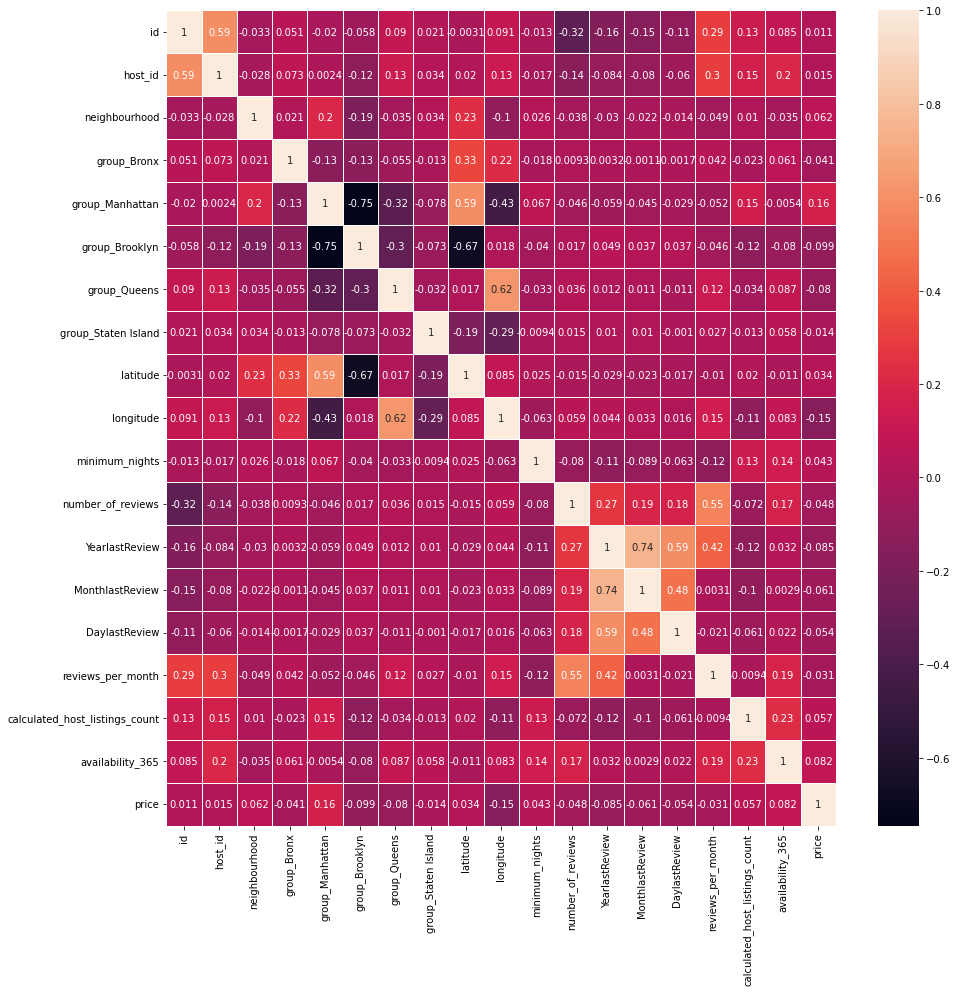

In [12]:
correlacio = dataset.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Observant els valors del dataset, veiem com la majoria de preus s'acomulen a menys de 1500€, encara que hi ha uns quants que es troben per sobre d'aquest llindar. Després de provar entre varis llindars, he decidit treure totes les mostres on el preu sigui major de 1500€, ja que obteniem una millor correlació entre els atributs.

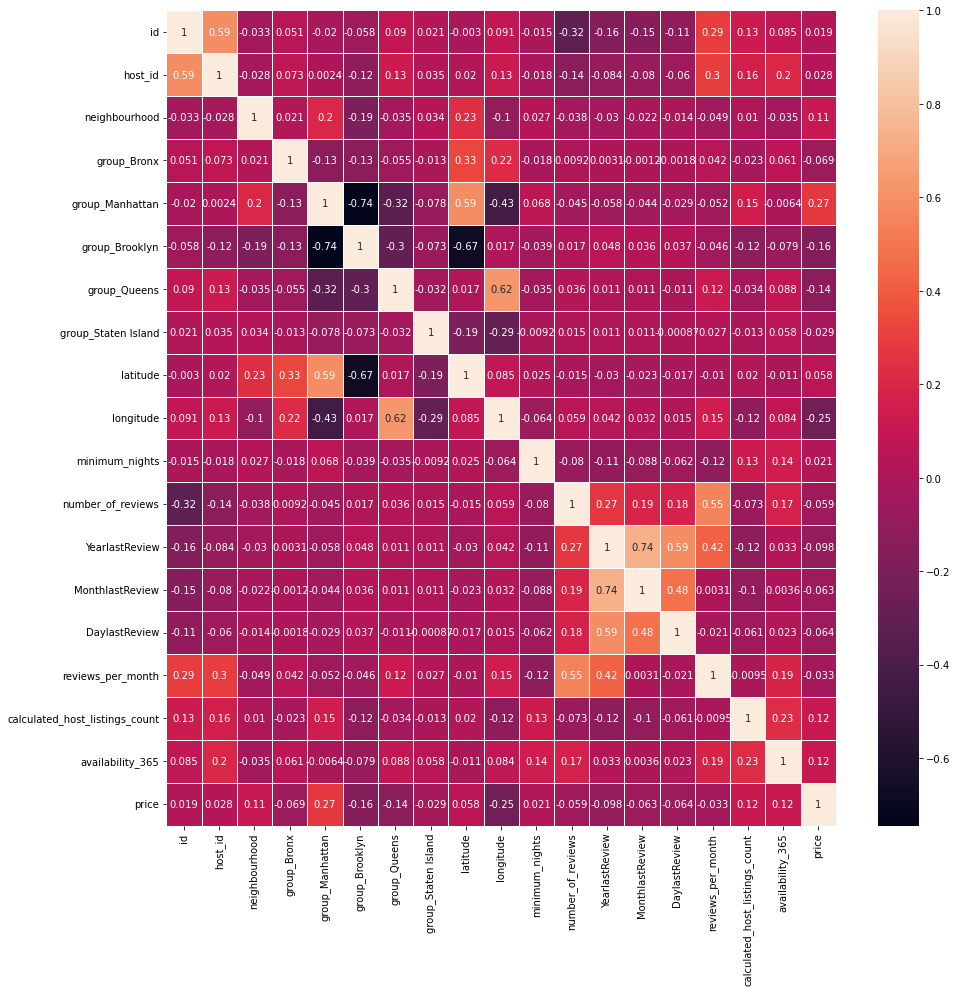

In [13]:
dataset = dataset.drop(dataset[dataset['price']>1500].index)
correlacio = dataset.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Per tal de veure la relació entre els atributs i l'atribut objectiu "price", generem uns diagrames scatter.
En el primer, observarem com la majoria de preus son molt baixos, per la qual cosa costa identificar una relació clara amb alguns dels atributs. Pels atributs binaris tampoc podem observar una relació notoria.

C:\Users\valen\AppData\Local\Temp\ipykernel_20668\2257146179.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

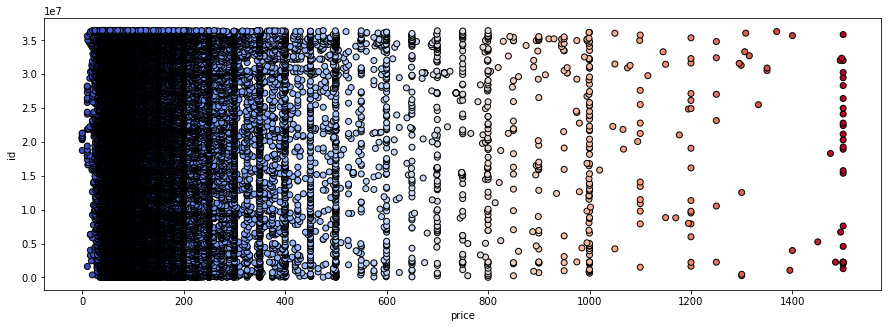

<Figure size 432x288 with 0 Axes>

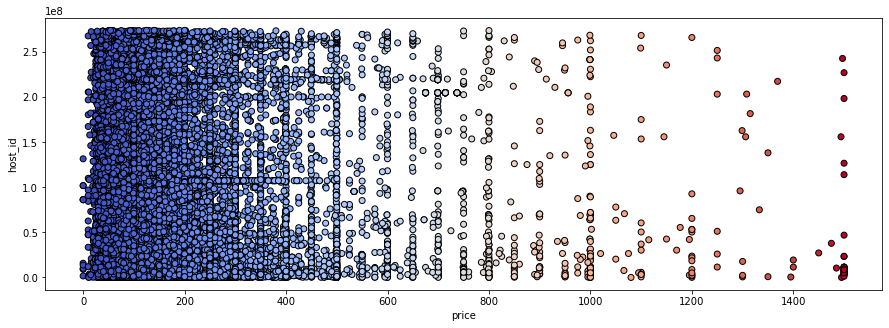

<Figure size 432x288 with 0 Axes>

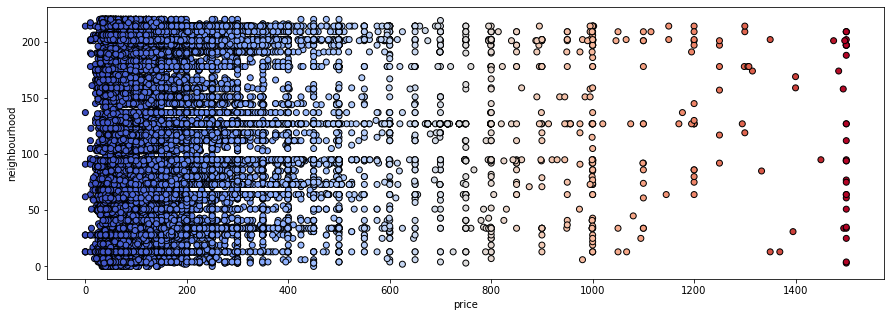

<Figure size 432x288 with 0 Axes>

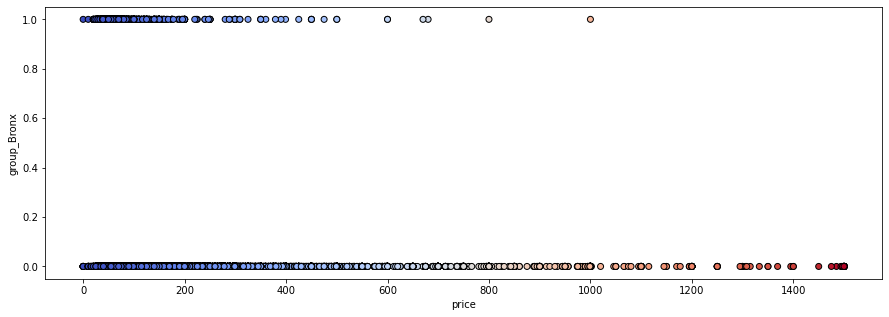

<Figure size 432x288 with 0 Axes>

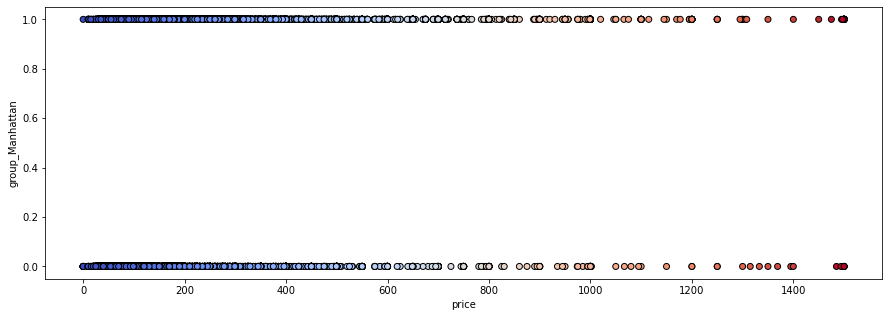

<Figure size 432x288 with 0 Axes>

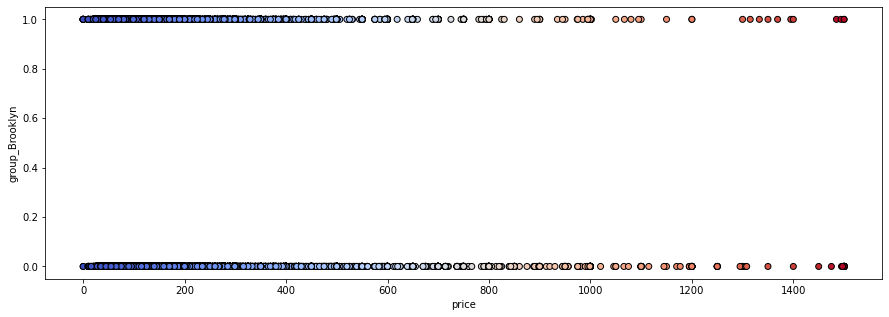

<Figure size 432x288 with 0 Axes>

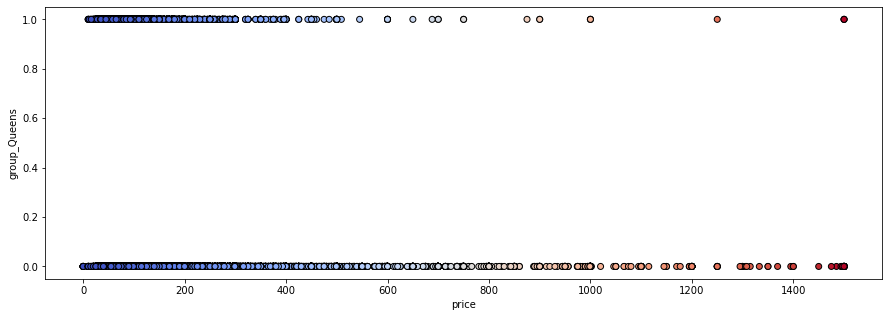

<Figure size 432x288 with 0 Axes>

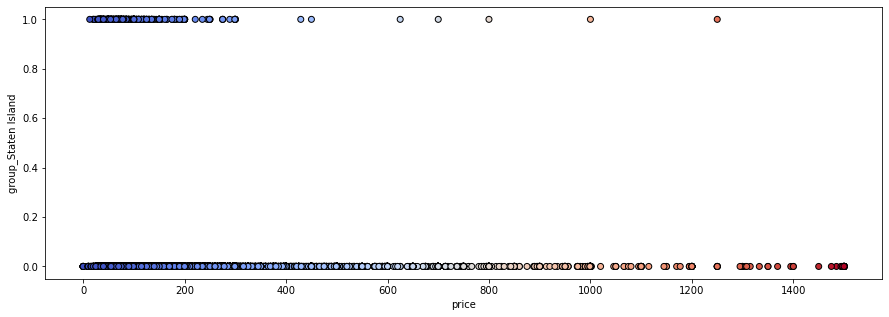

<Figure size 432x288 with 0 Axes>

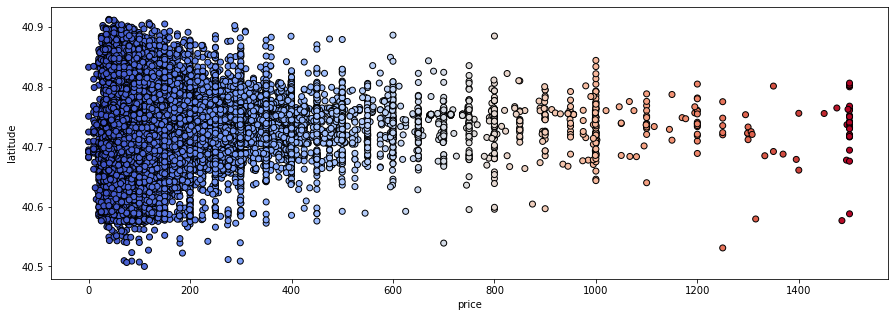

<Figure size 432x288 with 0 Axes>

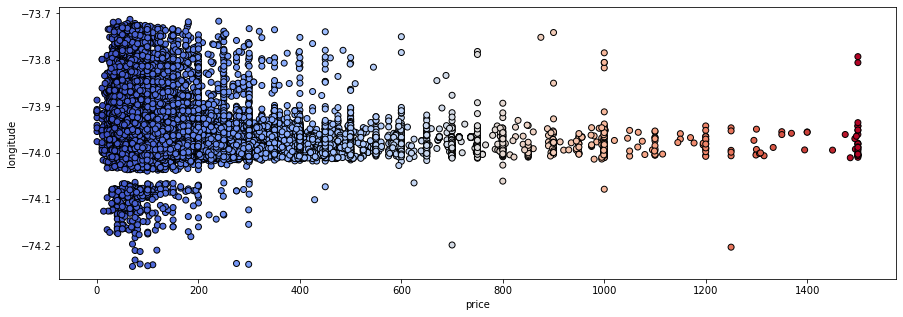

<Figure size 432x288 with 0 Axes>

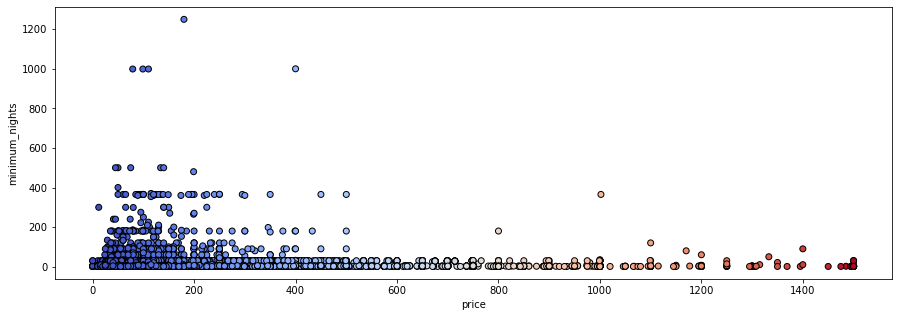

<Figure size 432x288 with 0 Axes>

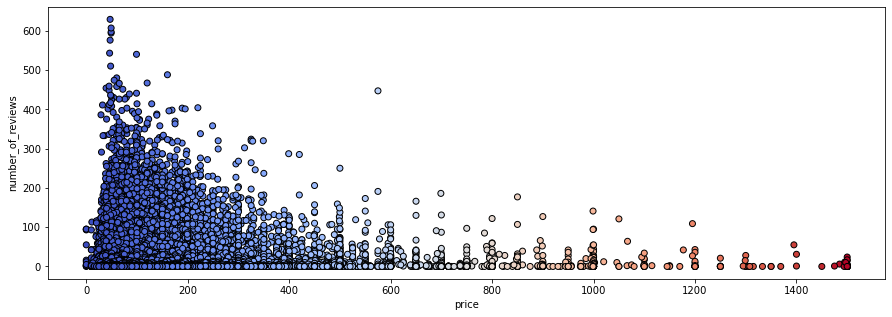

<Figure size 432x288 with 0 Axes>

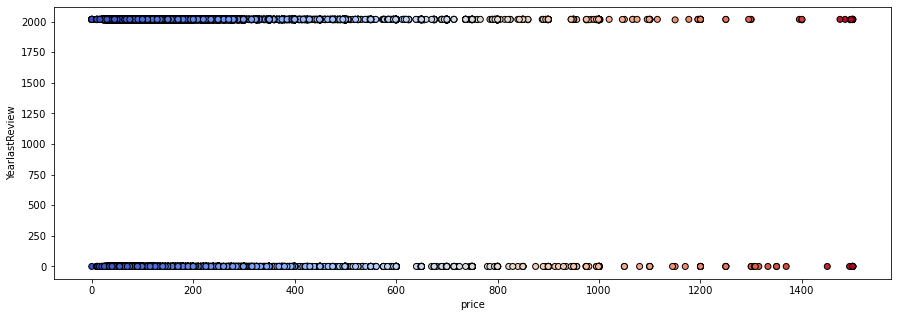

<Figure size 432x288 with 0 Axes>

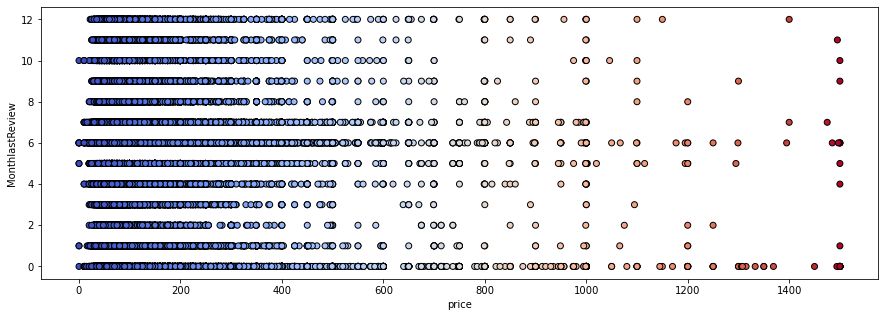

<Figure size 432x288 with 0 Axes>

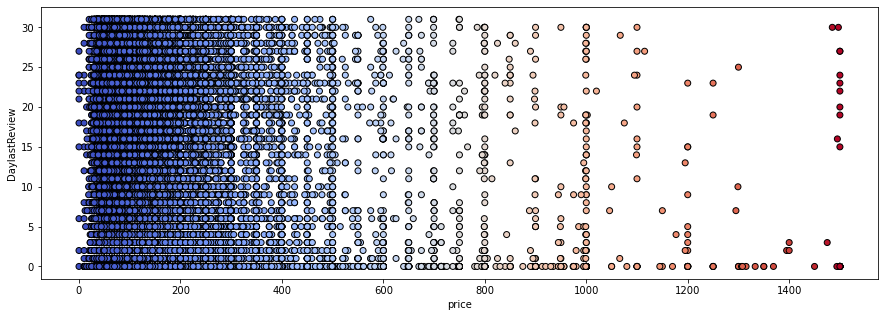

<Figure size 432x288 with 0 Axes>

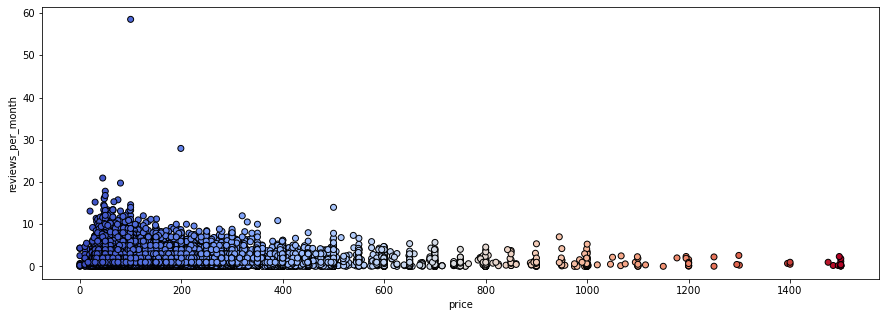

<Figure size 432x288 with 0 Axes>

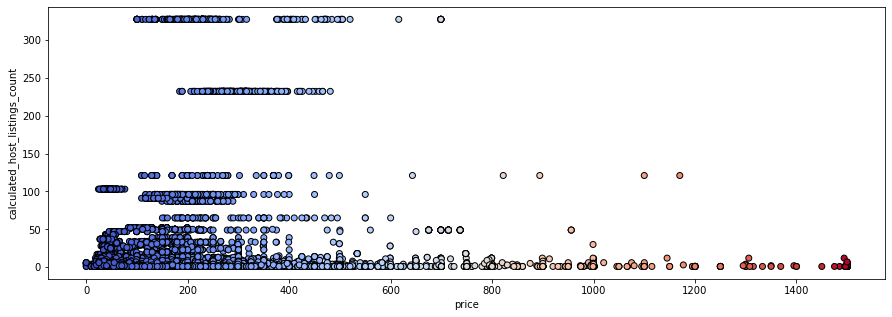

<Figure size 432x288 with 0 Axes>

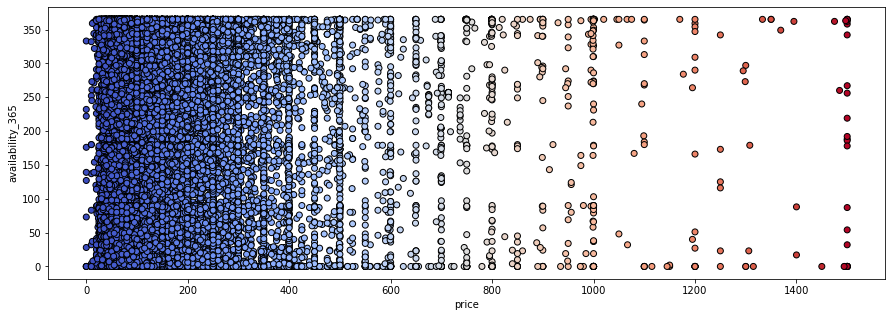

In [14]:
X = dataset.values[:, :18]
y = dataset.values[:, 18]
dataset_iterable = dataset.iloc[:, :-1]
for i, col in enumerate(dataset_iterable.columns):
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.ylabel(col)
    plt.xlabel('price')
    scatt = plt.scatter(y,X[:,i] , c=y, cmap=plt.cm.coolwarm, edgecolors='k')

En els atributs "minimum_nights" i "number_of_reviews" observem una relació logarítmica entre el preu i aquests atributs. Per tal de millorar la relació entre aquests atributs, vaig pensar en aplicar el logaritme del preu, per així veure una relació lineal entre els atributs previament esmentats.

C:\Users\valen\AppData\Local\Temp\ipykernel_20668\3756970171.py:9: RuntimeWarning: divide by zero encountered in log
  logy = np.log(y)
C:\Users\valen\AppData\Local\Temp\ipykernel_20668\3756970171.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

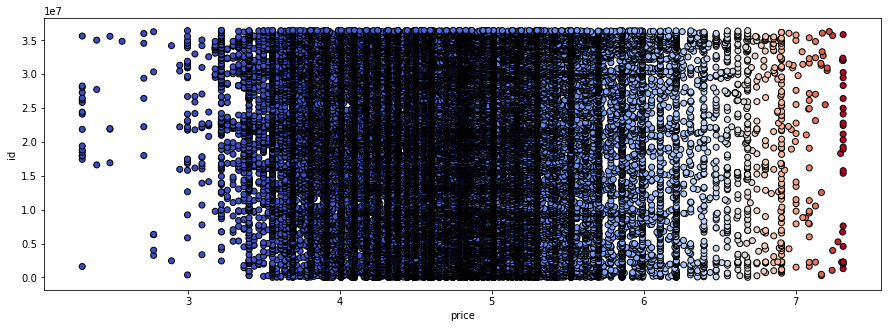

<Figure size 432x288 with 0 Axes>

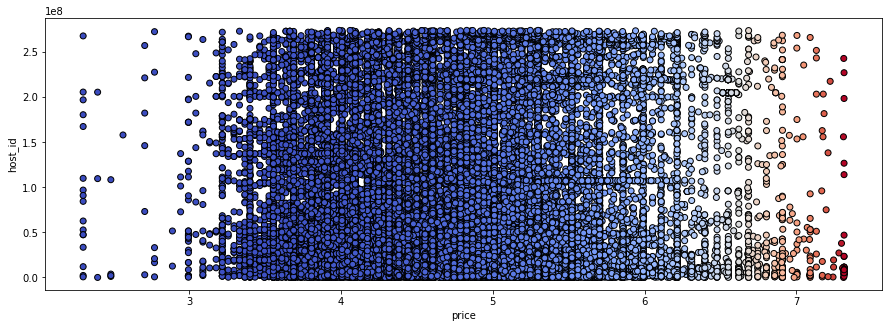

<Figure size 432x288 with 0 Axes>

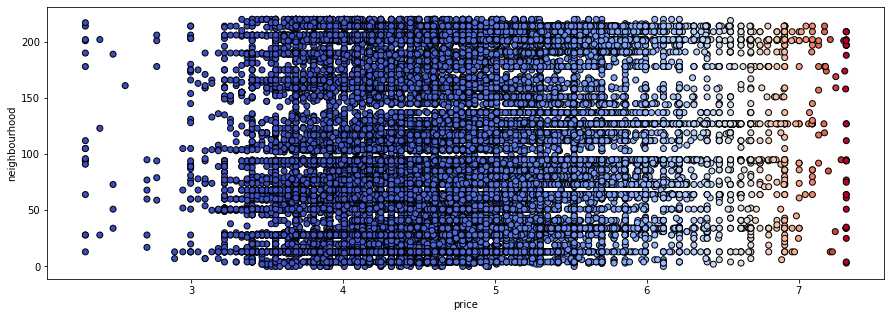

<Figure size 432x288 with 0 Axes>

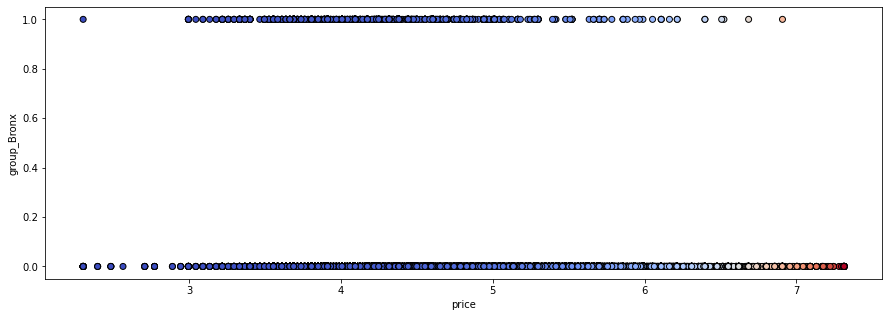

<Figure size 432x288 with 0 Axes>

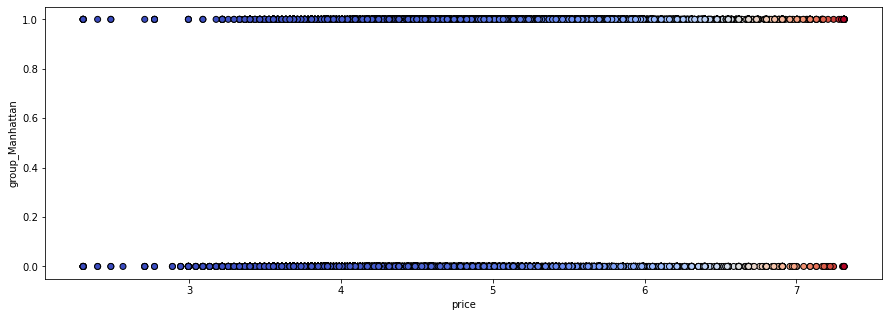

<Figure size 432x288 with 0 Axes>

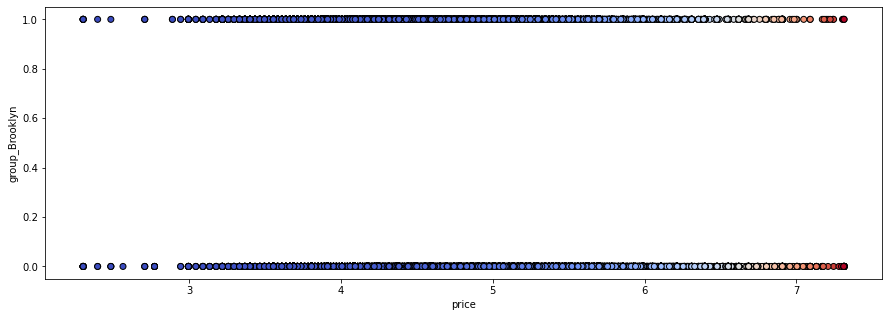

<Figure size 432x288 with 0 Axes>

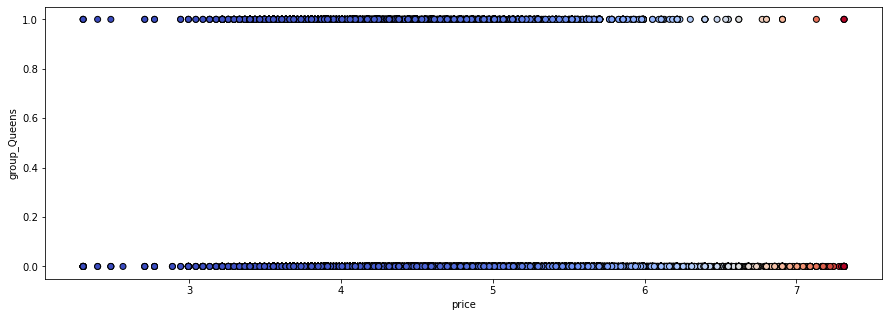

<Figure size 432x288 with 0 Axes>

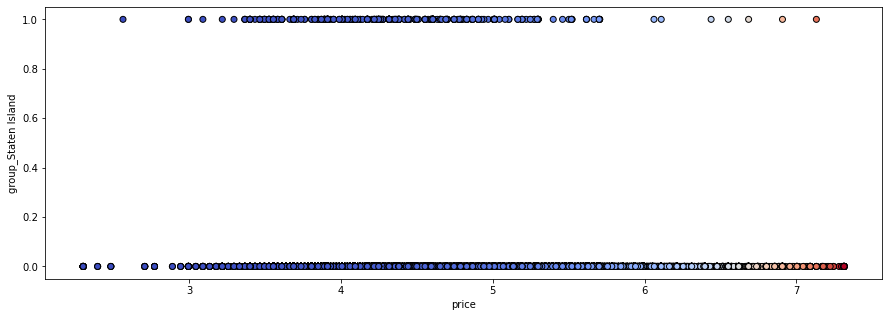

<Figure size 432x288 with 0 Axes>

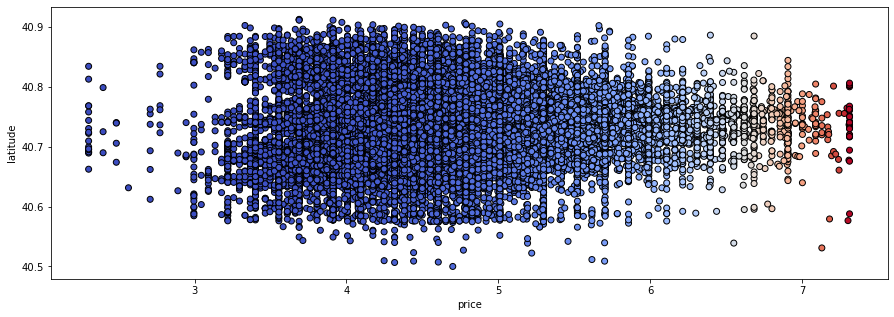

<Figure size 432x288 with 0 Axes>

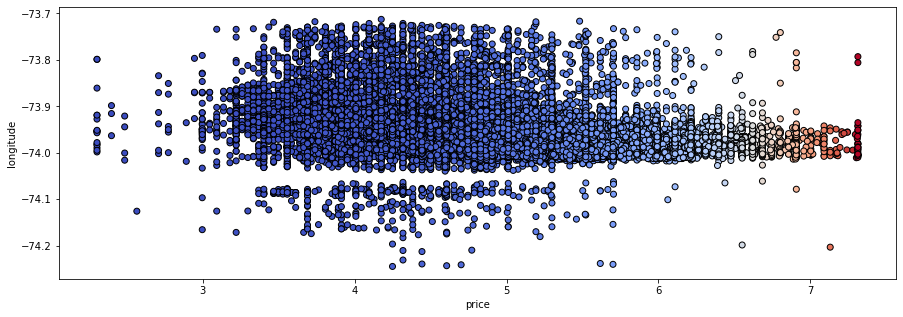

<Figure size 432x288 with 0 Axes>

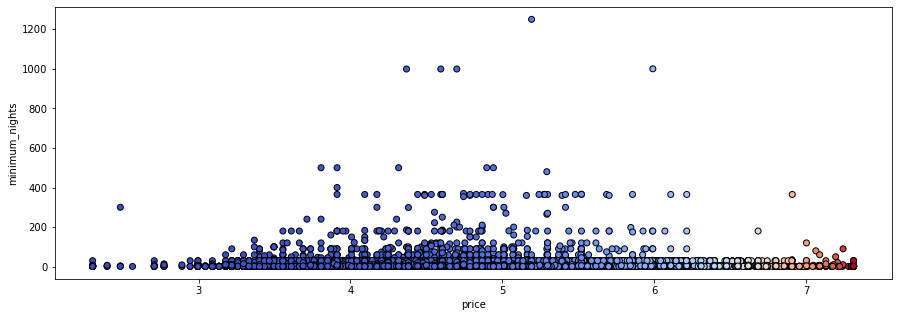

<Figure size 432x288 with 0 Axes>

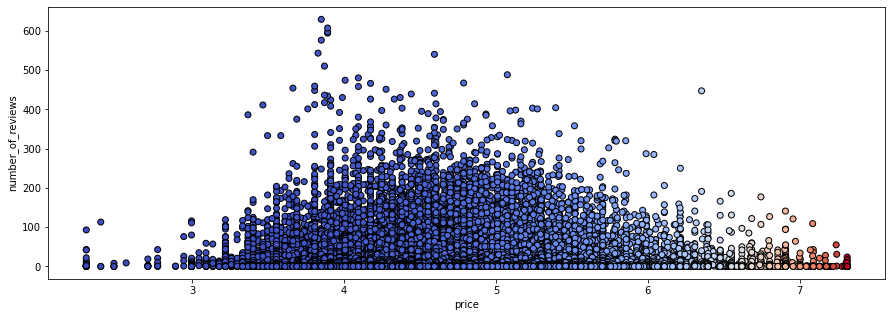

<Figure size 432x288 with 0 Axes>

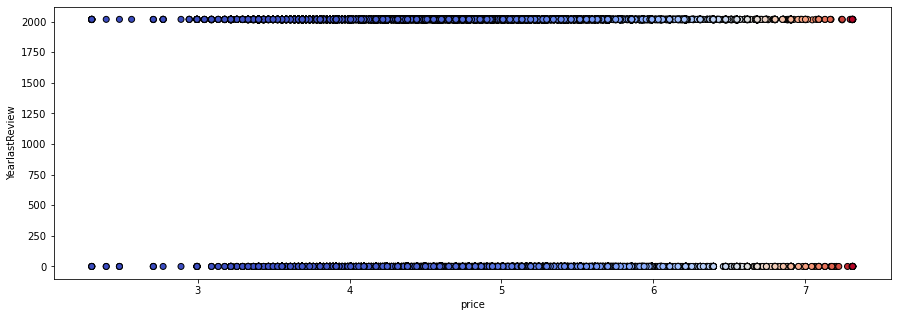

<Figure size 432x288 with 0 Axes>

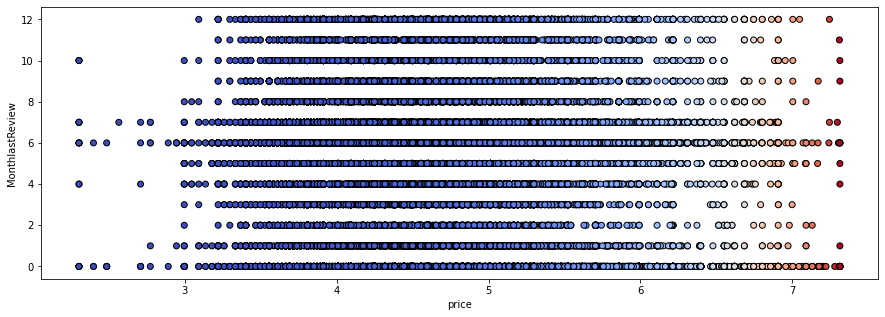

<Figure size 432x288 with 0 Axes>

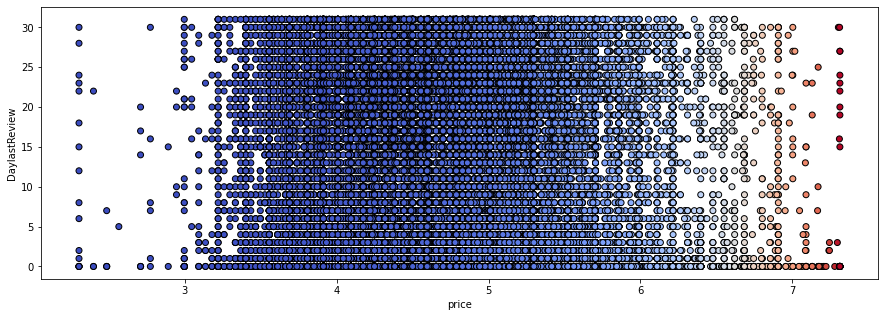

<Figure size 432x288 with 0 Axes>

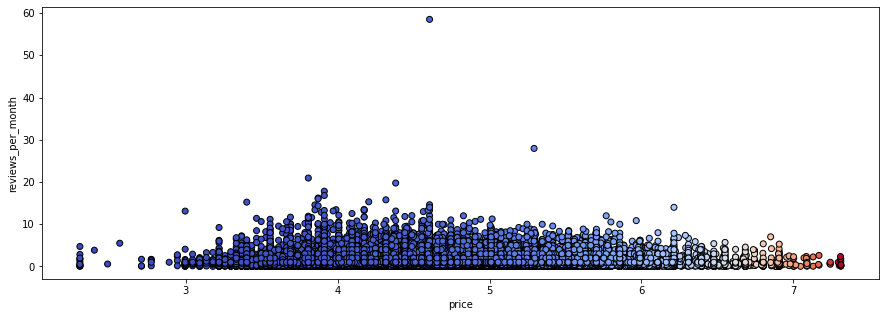

<Figure size 432x288 with 0 Axes>

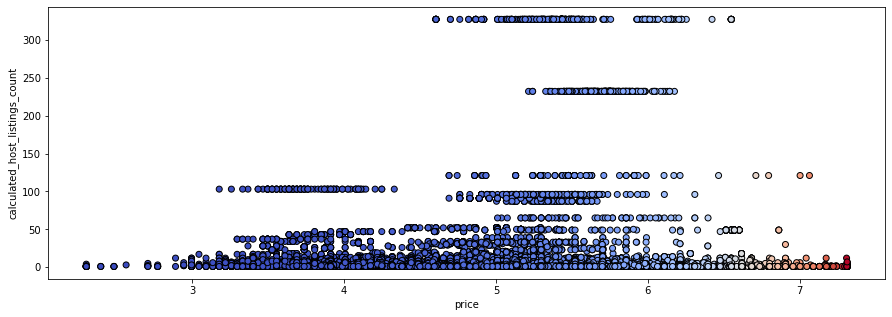

<Figure size 432x288 with 0 Axes>

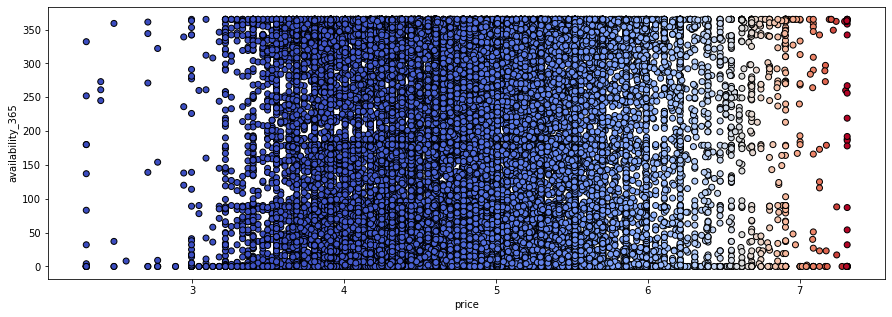

In [15]:
X = dataset.values[:, :18]
y = dataset.values[:, 18]
dataset_iterable = dataset.iloc[:, :-1]
for i, col in enumerate(dataset_iterable.columns):
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.ylabel(col)
    plt.xlabel('price')
    logy = np.log(y)
    scatt = plt.scatter(logy,X[:,i] , c=y, cmap=plt.cm.coolwarm, edgecolors='k')

Observem, despres d'aplicar el logaritme del preu, auq els atributs que mostraven una distribució logarítmica, ara presenten una distribució gaussiana, molt més addient per tractar regressió.

In [16]:
'''X = dataset.values[:, :17]
y = dataset.values[:, 17]
plt.figure()
plt.figure(figsize=(15, 5))
plt.ylabel('number_of_reviews')
plt.xlabel('price')
logy = np.log(y)
scatt = plt.scatter(logy, X[:,10], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

plt.figure()
plt.figure(figsize=(15, 5))
plt.ylabel('number_of_reviews')
plt.xlabel('price')
scatt = plt.scatter(y, X[:,10], c=y, cmap=plt.cm.coolwarm, edgecolors='k')'''

"X = dataset.values[:, :17]\ny = dataset.values[:, 17]\nplt.figure()\nplt.figure(figsize=(15, 5))\nplt.ylabel('number_of_reviews')\nplt.xlabel('price')\nlogy = np.log(y)\nscatt = plt.scatter(logy, X[:,10], c=y, cmap=plt.cm.coolwarm, edgecolors='k')\n\nplt.figure()\nplt.figure(figsize=(15, 5))\nplt.ylabel('number_of_reviews')\nplt.xlabel('price')\nscatt = plt.scatter(y, X[:,10], c=y, cmap=plt.cm.coolwarm, edgecolors='k')"

Crearem un nou atribut, anomenat logprice, el qual representarà el logaritme de cada preu. Representem de nou el dataset en una taula de correlació per tal de veure la diferncia de correlacions que mostren "price" i "logprice".

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


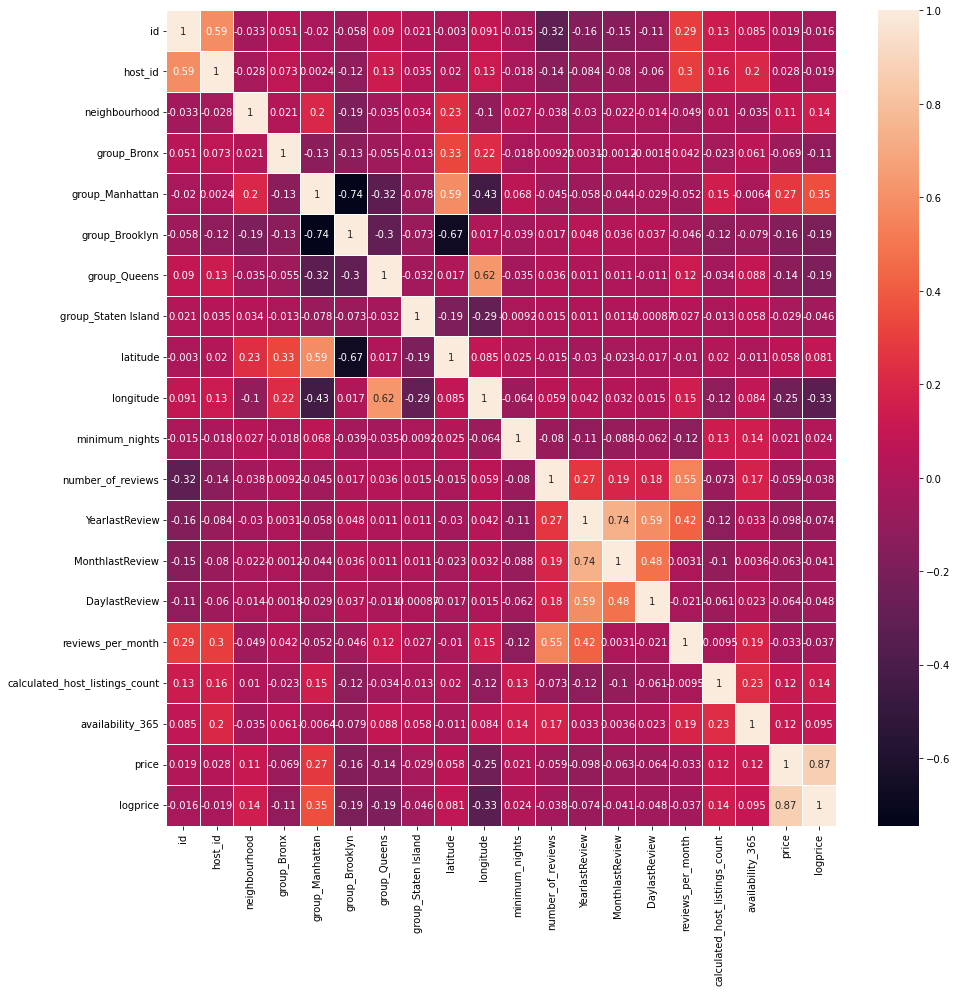

In [17]:
dataset['logprice'] = dataset.loc[:, 'price']
dataset['logprice'] = np.log(dataset['price'])
correlacio = dataset.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

Observem que hi ha una lleugera millora a la correlació amb logprice però, al ser tan petita, mantindrem els dos atributs per veure com van evolucionant.
A continuació, reduïm el dataset per tal de treballar només amb els atributs que tinguin una correlació amb price i logprice major de 0.1.

In [18]:
bronx = dataset['group_Bronx']
manhattan = dataset['group_Manhattan']
brooklyn = dataset['group_Brooklyn']
queens = dataset['group_Queens']
neighbourhood = dataset['neighbourhood']
longitude = dataset['longitude']
calculate = dataset['calculated_host_listings_count']

available = dataset['availability_365']
price = dataset['logprice']
price2 = dataset['price']
dataset_alta = pd.concat([bronx, manhattan, brooklyn, queens, neighbourhood, longitude, calculate, available, price, price2], axis = 1)
dataset_alta.head(10)
display(dataset_alta)

group_Bronx  group_Manhattan  group_Brooklyn  group_Queens  \
0                0                0               1             0   
1                0                1               0             0   
2                0                1               0             0   
3                0                0               1             0   
4                0                1               0             0   
...            ...              ...             ...           ...   
48890            0                0               1             0   
48891            0                0               1             0   
48892            0                1               0             0   
48893            0                1               0             0   
48894            0                1               0             0   

       neighbourhood  longitude  calculated_host_listings_count  \
0                108    -73.972                               6   
1                127    -73.984                               2   
2                 94    -73.942                               1   
3                 41    -73.960                               1   
4                 61    -73.944                               1   
...              ...        ...                             ...   
48890             13    -73.950                               2   
48891             28    -73.933                               2   
48892             94    -73.949                               1   
48893             95    -73.991                               6   
48894             95    -73.989                               1   

       availability_365  logprice  price  
0                   365     5.004    149  
1                   355     5.416    225  
2                   365     5.011    150  
3                   194     4.489     89  
4                     0     4.382     80  
...                 ...       ...    ...  
48890                 9     4.248     70  
48891                36     3.689     40  
48892                27     4.745    115  
48893                 2     4.007     55  
48894                23     4.500     90  

[48756 rows x 10 columns]

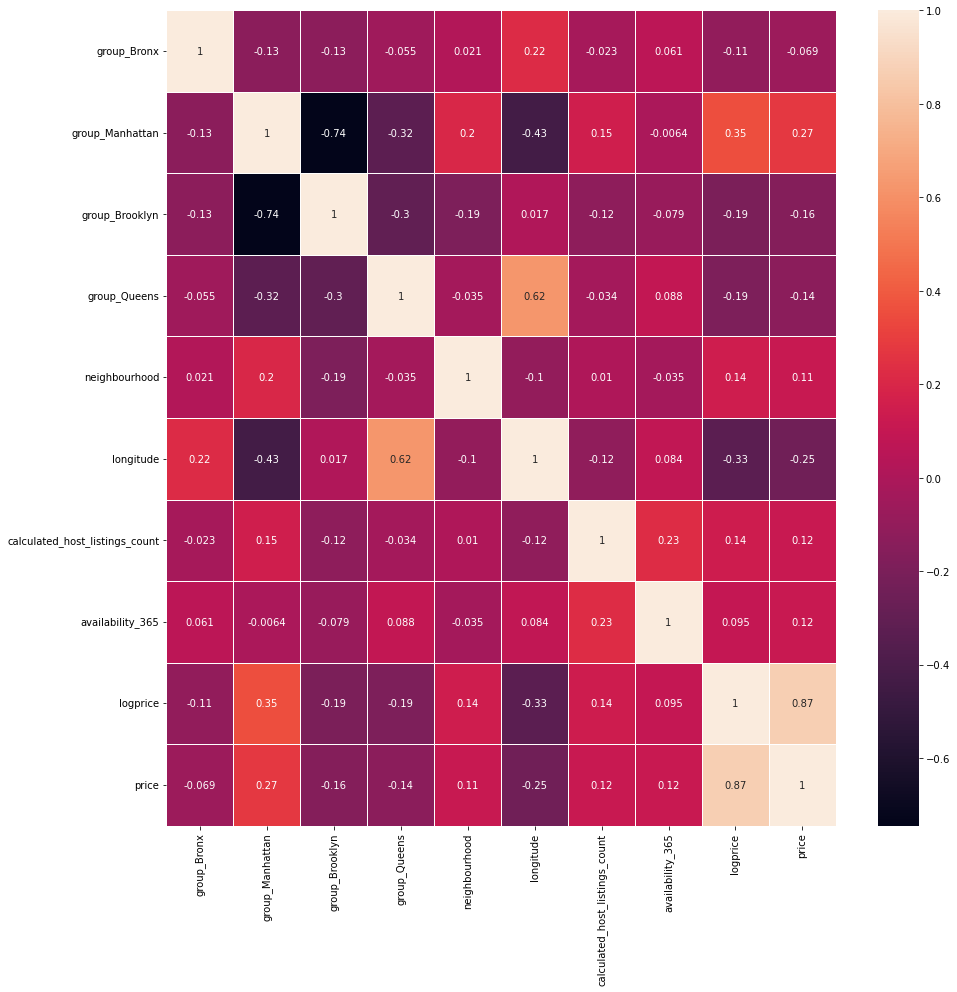

In [19]:
correlacio = dataset_alta.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

In [20]:
dataset_alta.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48756 entries, 0 to 48894
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   group_Bronx                     48756 non-null  uint8  
 1   group_Manhattan                 48756 non-null  uint8  
 2   group_Brooklyn                  48756 non-null  uint8  
 3   group_Queens                    48756 non-null  uint8  
 4   neighbourhood                   48756 non-null  int16  
 5   longitude                       48756 non-null  float64
 6   calculated_host_listings_count  48756 non-null  int64  
 7   availability_365                48756 non-null  int64  
 8   logprice                        48756 non-null  float64
 9   price                           48756 non-null  int64  
dtypes: float64(2), int16(1), int64(3), uint8(4)
memory usage: 2.5 MB


Observem el nombre de NaNs que tenen els atributs restants al dataset, i veiem com cap de les columnes mostre cap valor NaN.

group_Bronx 
NaNs: 0

group_Manhattan 
NaNs: 0

group_Brooklyn 
NaNs: 0

group_Queens 
NaNs: 0

neighbourhood 
NaNs: 0

longitude 
NaNs: 0

calculated_host_listings_count 
NaNs: 0

availability_365 
NaNs: 0

logprice 
NaNs: 0

price 
NaNs: 0



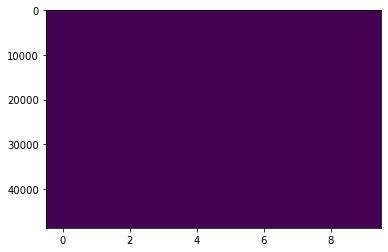

In [21]:
plt.imshow(dataset_alta.isna(), aspect='auto')
for i in dataset_alta.columns:
        print(f"{i} \nNaNs: {dataset_alta[i].isna().sum()}\n", )

AMB AIXÒ OBSERVEM QUE NO TENIM VALORS NULLS A CAP FILA DE CAP DELS ATRIBUTS AMB MAJOR CORRELACIÓ!!!!!!!!!!!!!!!!!!!!!!!

In [22]:
display(dataset_alta)

group_Bronx  group_Manhattan  group_Brooklyn  group_Queens  \
0                0                0               1             0   
1                0                1               0             0   
2                0                1               0             0   
3                0                0               1             0   
4                0                1               0             0   
...            ...              ...             ...           ...   
48890            0                0               1             0   
48891            0                0               1             0   
48892            0                1               0             0   
48893            0                1               0             0   
48894            0                1               0             0   

       neighbourhood  longitude  calculated_host_listings_count  \
0                108    -73.972                               6   
1                127    -73.984                               2   
2                 94    -73.942                               1   
3                 41    -73.960                               1   
4                 61    -73.944                               1   
...              ...        ...                             ...   
48890             13    -73.950                               2   
48891             28    -73.933                               2   
48892             94    -73.949                               1   
48893             95    -73.991                               6   
48894             95    -73.989                               1   

       availability_365  logprice  price  
0                   365     5.004    149  
1                   355     5.416    225  
2                   365     5.011    150  
3                   194     4.489     89  
4                     0     4.382     80  
...                 ...       ...    ...  
48890                 9     4.248     70  
48891                36     3.689     40  
48892                27     4.745    115  
48893                 2     4.007     55  
48894                23     4.500     90  

[48756 rows x 10 columns]

Al observar les dades, veiem com a la columna "price" hi ha 11 valors que son igual a zero. Això causa un problema ja que al aplicar el logaritme de zero, ens donava un valor erroni (-inf). Per tant, al ser només 11 mostres que presenten aquesta situació, he decidit borrar-les del dataset.

index 
Mean:24445.921 std:14112.887

group_Bronx 
Mean:0.022 std:0.148

group_Manhattan 
Mean:0.442 std:0.497

group_Brooklyn 
Mean:0.412 std:0.492

group_Queens 
Mean:0.116 std:0.320

neighbourhood 
Mean:107.096 std:68.733

longitude 
Mean:-73.952 std:0.046

calculated_host_listings_count 
Mean:7.157 std:33.002

availability_365 
Mean:112.574 std:131.512

logprice 
Mean:4.718 std:0.677

price 
Mean:143.660 std:127.822



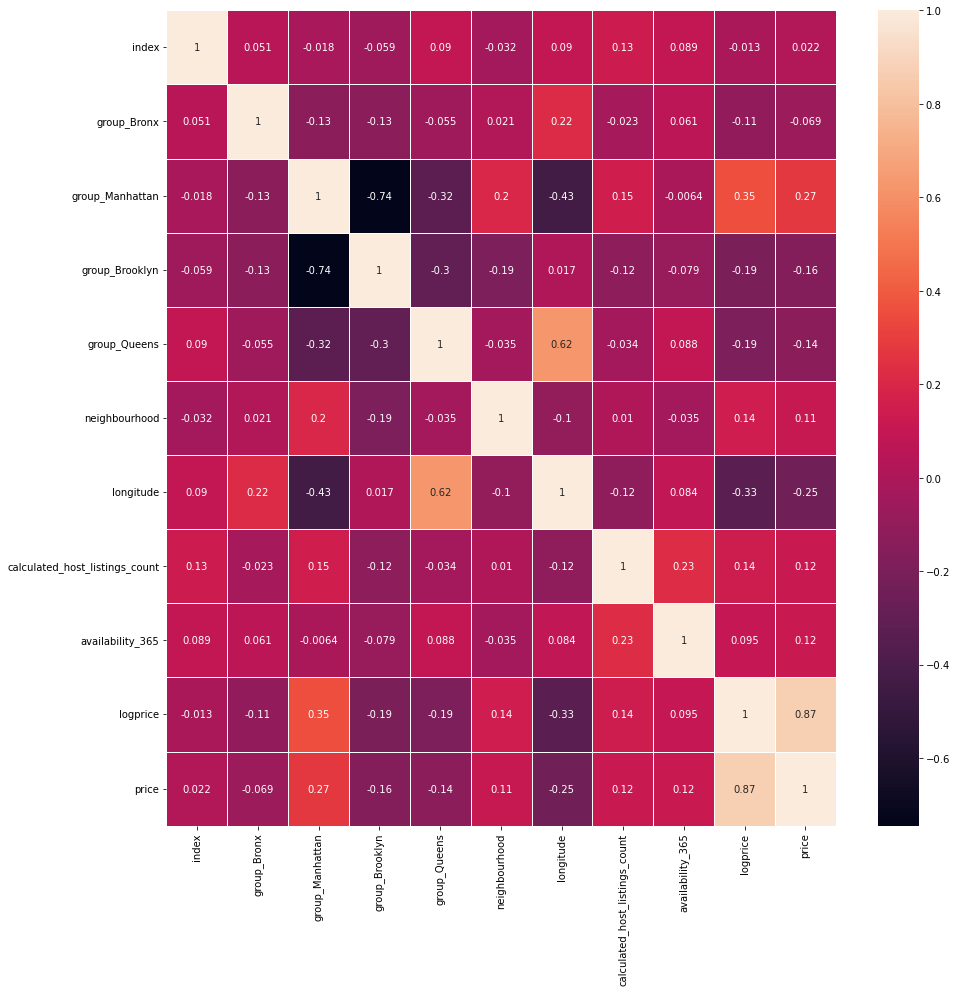

In [23]:
dataset_alta.replace(0, np.nan, inplace=True)
dataset_alta = dataset_alta.dropna(subset=["price"])
dataset_alta = dataset_alta.reset_index()
dataset_alta.replace(np.nan, 0, inplace=True)
for i in dataset_alta.columns:
    print(f"{i} \nMean:{dataset_alta[i].mean():.3f} std:{dataset_alta[i].std():.3f}\n" ,)
correlacio_alta = dataset_alta.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio_alta, annot=True, linewidths=.5)

A continuació normalitzarem tots aquells atributs continus. Hem dividit el dataset per tal de poder normalitzar només els atributs que ens interessa normalitzar, com seran: 'calculated_host_listings_count', 'availability_365', 'logprice', 'price'.
Per l'atribut availability_365, vaig plantejar dividir el seu valor per 365, ja que reduiria el seu domini a un de 0 a 1. Com que la normalització generava un resultat similar, vaig deixar-ho així.

In [24]:
from sklearn import preprocessing
dataset_alta = dataset_alta.drop(columns=['index'])
dataset_alta1 = dataset_alta.iloc[:, :4]
dataset_alta2 = dataset_alta[['longitude']]
a = dataset_alta[['calculated_host_listings_count', 'availability_365', 'logprice', 'price']]
dataset_norm = np.array(a)
X_scaled = preprocessing.normalize(dataset_norm)
a = pd.DataFrame(X_scaled)
a.columns =[ 'calculated_host_listings_count','availability_365', 'logprice', 'price']
dataset_def = pd.concat([dataset_alta1, dataset_alta2, a], axis = 1)
dataset_def.head(10)
display(dataset_def)

group_Bronx  group_Manhattan  group_Brooklyn  group_Queens  longitude  \
0            0.000            0.000           1.000         0.000    -73.972   
1            0.000            1.000           0.000         0.000    -73.984   
2            0.000            1.000           0.000         0.000    -73.942   
3            0.000            0.000           1.000         0.000    -73.960   
4            0.000            1.000           0.000         0.000    -73.944   
...            ...              ...             ...           ...        ...   
48740        0.000            0.000           1.000         0.000    -73.950   
48741        0.000            0.000           1.000         0.000    -73.933   
48742        0.000            1.000           0.000         0.000    -73.949   
48743        0.000            1.000           0.000         0.000    -73.991   
48744        0.000            1.000           0.000         0.000    -73.989   

       calculated_host_listings_count  availability_365  logprice  price  
0                               0.015             0.926     0.013  0.378  
1                               0.005             0.845     0.013  0.535  
2                               0.003             0.925     0.013  0.380  
3                               0.005             0.909     0.021  0.417  
4                               0.012             0.000     0.055  0.998  
...                               ...               ...       ...    ...  
48740                           0.028             0.127     0.060  0.990  
48741                           0.037             0.667     0.068  0.741  
48742                           0.008             0.228     0.040  0.973  
48743                           0.108             0.036     0.072  0.991  
48744                           0.011             0.247     0.048  0.968  

[48745 rows x 9 columns]

HEM NORMALITZAT ELS ATRIBUTS CONTINUS

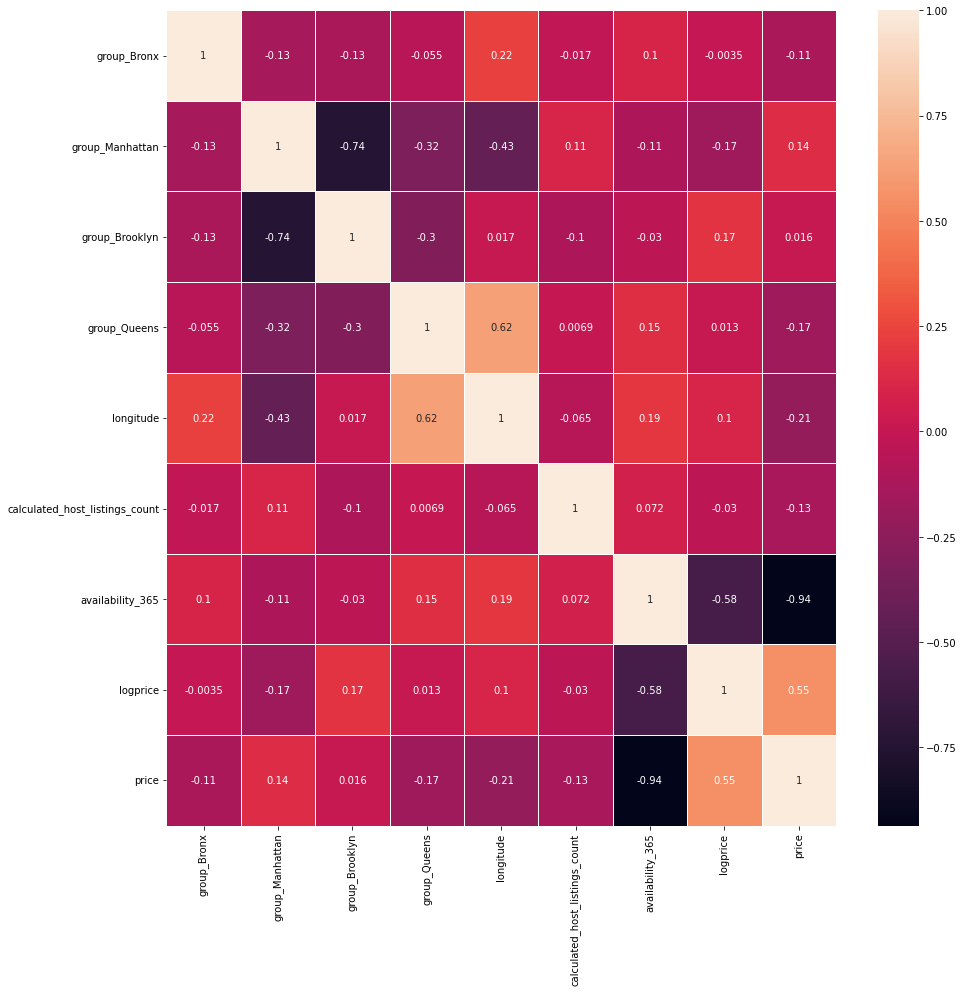

In [25]:
correlacio_alta = dataset_def.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio_alta, annot=True, linewidths=.5)

Ara ens ha sorgit una situació bastant curiosa. Al normalitzar les dades, l'atribut "availability_365" ha passat de tenir una correlació amb "price" de 0.12 a -0.94. He estat fent proves, i intentant entendre com és que ha succeit això, però no he pogut trobar cap explicació. Per tant, ens trobem en un punt on tenim un atribut que té una correlació molt gran amb "price", i una mica menor però encara gran amb "logprice". 

PRICE TE MILLOR CORRELACIONS QUE LOGPRICE, I BROOKLYN NO TE BONA CORRELACIO. ELS BORREM

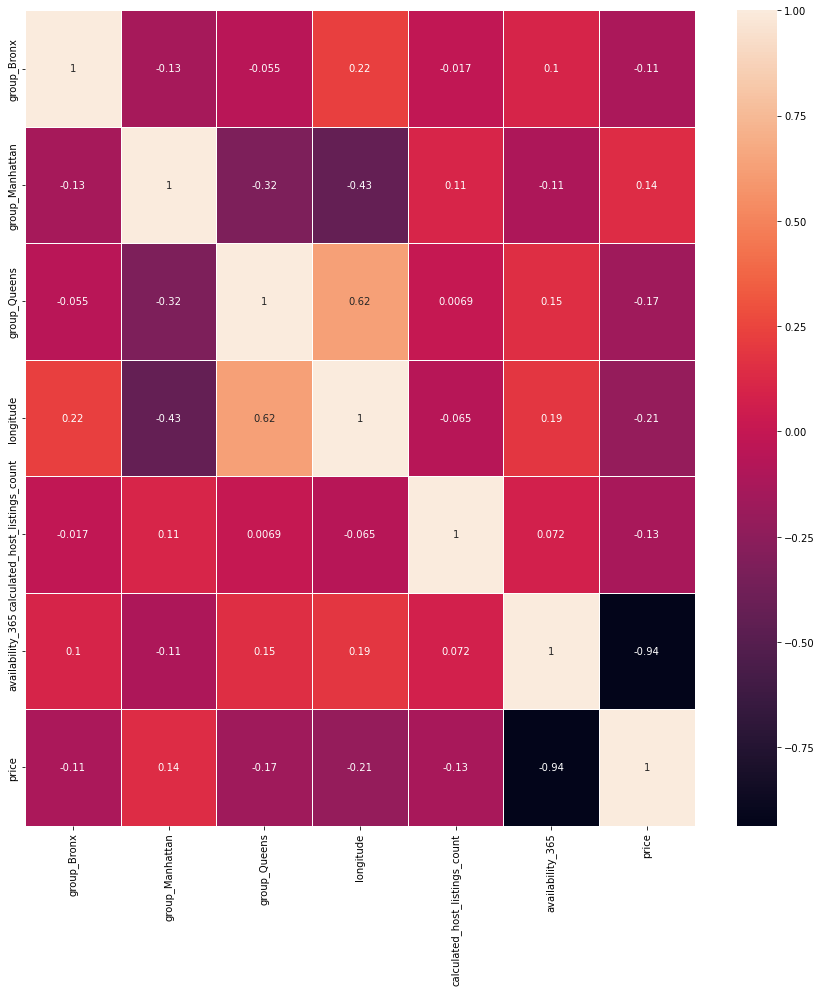

In [26]:
dataset_def = dataset_def.drop(columns=['group_Brooklyn', 'logprice'])
correlacio_alta = dataset_def.corr()

plt.figure(figsize=(15,15))
ax = sns.heatmap(correlacio_alta, annot=True, linewidths=.5)

In [27]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

In [28]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

def mse(v1, v2):
    return ((v1 - v2)**2).mean()

In [29]:
dataset_def.columns

Index(['group_Bronx', 'group_Manhattan', 'group_Queens', 'longitude',
       'calculated_host_listings_count', 'availability_365', 'price'],
      dtype='object')

In [30]:
dataset_def.head()

group_Bronx  group_Manhattan  group_Queens  longitude  \
0        0.000            0.000         0.000    -73.972   
1        0.000            1.000         0.000    -73.984   
2        0.000            1.000         0.000    -73.942   
3        0.000            0.000         0.000    -73.960   
4        0.000            1.000         0.000    -73.944   

   calculated_host_listings_count  availability_365  price  
0                           0.015             0.926  0.378  
1                           0.005             0.845  0.535  
2                           0.003             0.925  0.380  
3                           0.005             0.909  0.417  
4                           0.012             0.000  0.998

no segueix una distribució normal
no segueix una distribució normal
no segueix una distribució normal
no segueix una distribució normal
no segueix una distribució normal
no segueix una distribució normal
no segueix una distribució normal


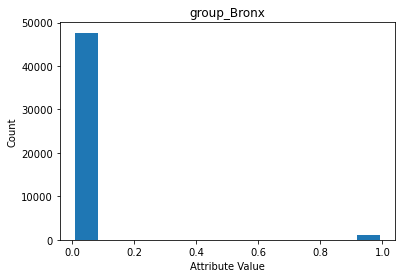

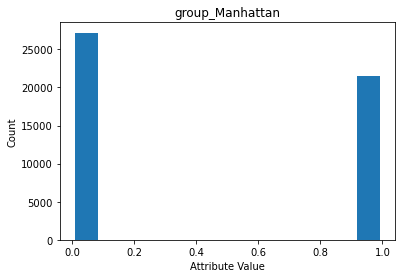

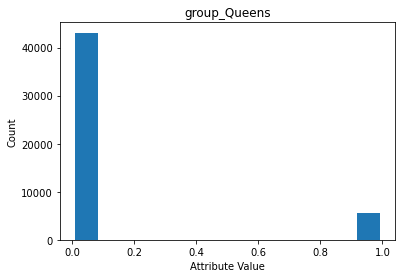

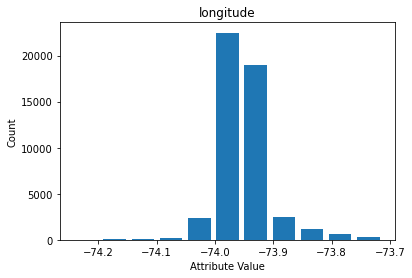

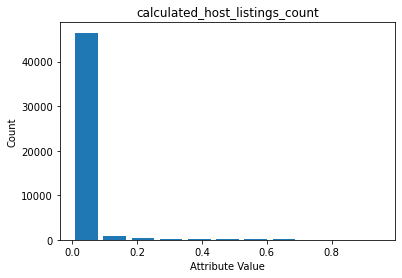

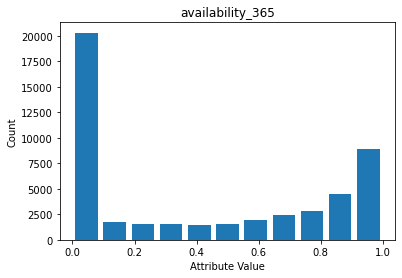

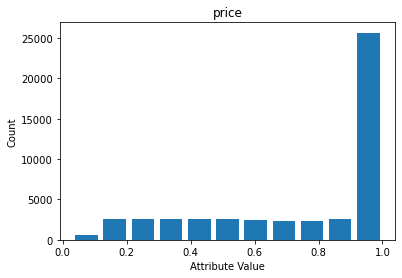

In [31]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest


X = dataset_def.values
X = X[:, :7]


lista = [0,1,2,3,4,5,6]
for i in lista: 
    plt.figure()
    plt.title(dataset_def.columns[i])
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    histN = plt.hist(X[:,i], bins=11, range=[np.min(X[:,i]), np.max(X[:,i])], histtype="bar", rwidth=0.8)
    stat,p=normaltest(X[:,i])
    alpha = 0.005
    if p < alpha:
        print('no segueix una distribució normal')
    else:
        print('si segueix una distribució normal')

cap dels atributs restants del dataset tenen una distribució normal

A continuació aplicarem regressió lineal simple, observant els resultats de cada un dels atributs amb "price".

Mean squeared error atribut  group_Bronx :  0.08470182148089729
R2 score:  0.012520676659817265 

Mean squeared error atribut  group_Manhattan :  0.08406461450453415
R2 score:  0.019949427338911363 

Mean squeared error atribut  group_Queens :  0.08328164041770958
R2 score:  0.02907757485607887 

Mean squeared error atribut  longitude :  0.08186515600747007
R2 score:  0.04559137635987176 

Mean squeared error atribut  calculated_host_listings_count :  0.0843103801809308
R2 score:  0.01708421712754493 

Mean squeared error atribut  availability_365 :  0.01064139418932458
R2 score:  0.8759394243270167 



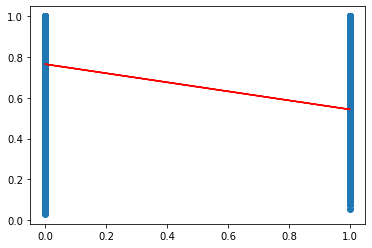

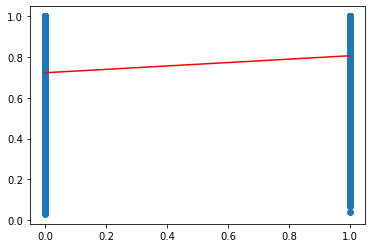

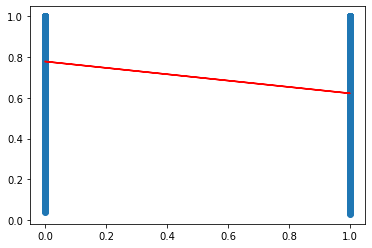

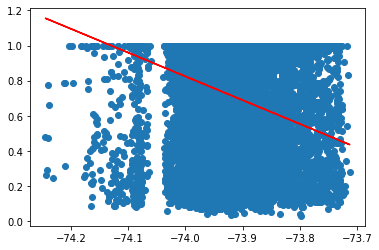

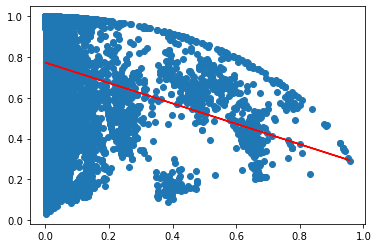

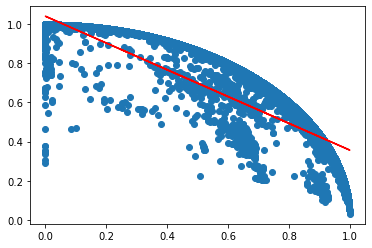

In [32]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
X = dataset_def.values
y = X[:,6]

X = X[:, :6]


for i in range(0,6):
    atribut = X[:,i].reshape(X.shape[0], 1) 
    regr = regression(atribut, y) 
    predicted = regr.predict(atribut)

    plt.figure()
    axN = plt.scatter(X[:,i], y)
    plt.plot(atribut[:,0], predicted, 'r')

    MSE = mse(y, predicted)
    r2 = r2_score(y, predicted)

    print("Mean squeared error atribut ", dataset_def.columns[i],  ": ", MSE)
    print("R2 score: ", r2, "\n")

    


Abans ja hem vist com "availability_365" té la major correlació amb "price". Ara, al trobar el MSE i el R2, veiem com de nou, aquest atribut és el que presenta millors resultats. l'atribut que presenta pitjor resultat és group_Bronx.

In [33]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = split_data(X, y) 

for i in range(x_train.shape[1]):
    x_t1 = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v1 = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t1 = np.reshape(x_t1,(x_t1.shape[0],1))
    x_v1 = np.reshape(x_v1,(x_v1.shape[0],1))

    regr = regression(x_t1, y_train)    
    error = mse(y_val, regr.predict(x_v1)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v1))
    
    if error < 20.00:
        print("Error en atribut %s: %f" %(dataset_def.columns[i], error))
        print("R2 score en atribut %s: %f" %(dataset_def.columns[i], r2), "\n")  ## entre 0 (fatal) i 1(molt be) 

Error en atribut group_Bronx: 0.085228
R2 score en atribut group_Bronx: 0.011853 

Error en atribut group_Manhattan: 0.085130
R2 score en atribut group_Manhattan: 0.012986 

Error en atribut group_Queens: 0.083900
R2 score en atribut group_Queens: 0.027248 

Error en atribut longitude: 0.082677
R2 score en atribut longitude: 0.041426 

Error en atribut calculated_host_listings_count: 0.084959
R2 score en atribut calculated_host_listings_count: 0.014973 

Error en atribut availability_365: 0.010505
R2 score en atribut availability_365: 0.878203 



Ara apliquem regressió lineal multivariada, utilitzant primer tots els atributs del dataset amb millors correlacions.

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
lm = LinearRegression() # Creating a Linear Regression object 'lm'
lm.fit(X_train,y_train) # Fit the linear model on to the 'lm' object itself i.e. no need to set this to another variable

print("The intercept term of the linear model:", lm.intercept_)

list_col = list(dataset_def.columns)
list_col.remove("price")
cdf = pd.DataFrame(data=lm.coef_, index=list_col, columns=["Coefficients"])
print(cdf)
regr = regression(X_train, y_train)
r2 = r2_score(y_test, regr.predict(X_test))
train_pred=lm.predict(X_train)
print("MSE value of this fit:",round(metrics.mean_squared_error(y_train,train_pred),3))
print("R2 score:", r2)

The intercept term of the linear model: -8.196669584794558
                                Coefficients
group_Bronx                           -0.024
group_Manhattan                        0.020
group_Queens                          -0.009
longitude                             -0.125
calculated_host_listings_count        -0.269
availability_365                      -0.674
MSE value of this fit: 0.01
R2 score: 0.8824321802512641


Observem com, al aplicar la multivariada, obtenim uns millors resultats que els obtinguts al fer simple amb només availability_365. Com seguim veient que el que obté un millor coeficient és availability_365, provarem de fer regressió sense ell, per veure quins son els següents més importants.

In [35]:
proba = pd.concat([dataset_def["group_Bronx"], dataset_def["group_Manhattan"], dataset_def["group_Queens"],dataset_def["longitude"], dataset_def["calculated_host_listings_count"], dataset_def["price"]], axis = 1)

X = proba.values
y = X[:,5]

X = X[:, :5]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
lm = LinearRegression() # Creating a Linear Regression object 'lm'
lm.fit(X_train,y_train) # Fit the linear model on to the 'lm' object itself i.e. no need to set this to another variable

print("The intercept term of the linear model:", lm.intercept_)

list_col = list(proba.columns)
list_col.remove("price")
cdf = pd.DataFrame(data=lm.coef_, index=list_col, columns=["Coefficients"])
print(cdf)
regr = regression(X_train, y_train)
r2 = r2_score(y_test, regr.predict(X_test))
train_pred=lm.predict(X_train)
print("MSE value of this fit:",round(metrics.mean_squared_error(y_train,train_pred),3))
print("R2 score:", r2)

The intercept term of the linear model: -63.77893413915317
                                Coefficients
group_Bronx                           -0.159
group_Manhattan                        0.037
group_Queens                          -0.060
longitude                             -0.873
calculated_host_listings_count        -0.568
MSE value of this fit: 0.079
R2 score: 0.07572737613283653


Hem vist com el resultat de R2 ha empitjorat considerablement degut a no utilitzar availability_365 a la regressió. Tot i així, hem pogut observar com, els atributs més importants sense utilitzar l'altre, son longitude, i calculated_host_listing_count.

Utilitzem ara Availability_365 junt amb els que donen un coeficient de més de 0.1

In [36]:
proba = pd.concat([dataset_def["group_Bronx"], dataset_def["longitude"], dataset_def["calculated_host_listings_count"], dataset_def["availability_365"], dataset_def["price"]], axis = 1)

X = proba.values
y = X[:,4]

X = X[:, :4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
lm = LinearRegression() # Creating a Linear Regression object 'lm'
lm.fit(X_train,y_train) # Fit the linear model on to the 'lm' object itself i.e. no need to set this to another variable

print("The intercept term of the linear model:", lm.intercept_)

list_col = list(proba.columns)
list_col.remove("price")
cdf = pd.DataFrame(data=lm.coef_, index=list_col, columns=["Coefficients"])
print(cdf)
regr = regression(X_train, y_train)
r2 = r2_score(y_test, regr.predict(X_test))
train_pred=lm.predict(X_train)
print("MSE value of this fit:",round(metrics.mean_squared_error(y_train,train_pred),3))
print("R2 score:", r2)

The intercept term of the linear model: -17.84912611208098
                                Coefficients
group_Bronx                           -0.023
longitude                             -0.255
calculated_host_listings_count        -0.260
availability_365                      -0.675
MSE value of this fit: 0.01
R2 score: 0.8811703633806482


Observem com, al no utilitzar els dos atributs que mostraven menys coeficients, obtenim un R2 gairebé identic al primer, reafirmant la idea de que és gairebé únicament availability_365 l'atribut que determina R2.

### PCA

Ara aplicarem analisi de components principals, mètode que ens permet estudiar i visualitzar conjunts de dades multidimensionals.

Principalment, utilitzarem aquest mètode per reduïr la dimensionalitat del dataset, i veure com redistribueix els coeficients a l'hora de fer regressió, i quin valor de R2 dona com a resultat.

In [37]:
dataset_def.head()

group_Bronx  group_Manhattan  group_Queens  longitude  \
0        0.000            0.000         0.000    -73.972   
1        0.000            1.000         0.000    -73.984   
2        0.000            1.000         0.000    -73.942   
3        0.000            0.000         0.000    -73.960   
4        0.000            1.000         0.000    -73.944   

   calculated_host_listings_count  availability_365  price  
0                           0.015             0.926  0.378  
1                           0.005             0.845  0.535  
2                           0.003             0.925  0.380  
3                           0.005             0.909  0.417  
4                           0.012             0.000  0.998

In [38]:
dst = dataset_def.drop(["price"], axis = 1)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dst.head()

group_Bronx  group_Manhattan  group_Queens  longitude  \
0        0.000            0.000         0.000    -73.972   
1        0.000            1.000         0.000    -73.984   
2        0.000            1.000         0.000    -73.942   
3        0.000            0.000         0.000    -73.960   
4        0.000            1.000         0.000    -73.944   

   calculated_host_listings_count  availability_365  
0                           0.015             0.926  
1                           0.005             0.845  
2                           0.003             0.925  
3                           0.005             0.909  
4                           0.012             0.000

In [39]:
dataset_x = dst
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(dataset_x)
pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)

In [40]:
df = pd.DataFrame(reduced, columns = ['pc1','pc2','pc3','pc4'])
df['price']=dataset_def['price']

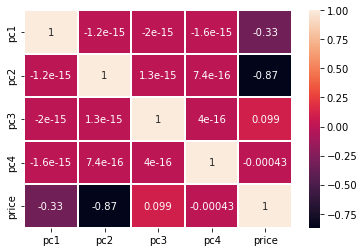

In [41]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio =df.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.25)
#print(correlacio['consume'])

In [42]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2,random_state=1)
#test malo

In [43]:
import statsmodels.formula.api as sm1
dta=dataset_def.values
train
est = sm1.ols(formula='price ~ pc1+pc2+pc3+pc4',data=train)
print(est.fit().summary())
model=est.fit()
ypred=model.predict(test)
price_test=test.filter(['price'])
price_test=price_test.values
price_test
error = mse(price_test, np.array(ypred)) # calculem error
r2 = r2_score(price_test,np.array(ypred))
print("Error en test : %f" %(error))
print("R2 score en test : %f" %(r2))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 7.032e+04
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:15:50   Log-Likelihood:                 33568.
No. Observations:               38996   AIC:                        -6.713e+04
Df Residuals:                   38991   BIC:                        -6.708e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7595      0.001   1465.843      0.0

Hem observat com, al aplicar PCA al dataset de millors correlacions, ens dona un resultat molt similar al que teniem al fer regressió multivariada. Observem com ha generat 4 components principals, donant-li a un d'ells un coeficient de -0.64. Podem arribar a la conclusió de que aquest component principal (PC2), té molta relació amb availability_365, ja que es tracta de l'atribut que més afecta a la regressió.

## CONCLUSIONS FINALS

Després de fer diferents proves, i veure com afectaven al resultat de R2, ens hem trobat amb que indiferentment del que fessim a l'hora de fer regressió multivariada, l'atribut availability_365 feia que hi hagues un molt bon resultat. Segueixo sense comprendre del tot com ha pogut obtenir tanta correlació amb "price" pel simple fet d'haver normalitzat les dades. Tot i no haver pogut explicar el motiu darrere d'aquest fet, he seguit treballant a partir de les dades mostrades, i he obtingut un model que, tot i ser inesperat i poc lògic, dona uns bons resultats. Tant fent PCA, com regressió simple, com multivariada, hem obtingut un R2 més gran de 0.85, la qual cosa ens reafirma que hi havia massa correlació entre price i availability. Tot i que aquests resultats probablement podrien haver-se explicat millor, i haver-se treballat més, considero que he fet una molt bona feina a l'hora de preprocessar les dades, i crear el model.